In [5]:
import GSM.MGSM_inference as inf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
C1d = np.array([[1.]])
def F1d(dt):
    return np.exp(-10*dt)*np.array([[1]])
def Q1d(dt):
    return inf.Q_self_con(C1d,F1d(dt))

def NC(snr):
    return C1d/(snr**2)

In [3]:
out = []

for dt in np.logspace(-2,-1,10):
    I = 20*np.ones([2,int(2./dt),1])
    resp = inf.att_gexp(0,I,C1d,Q1d(dt),NC(1.),F1d(dt))
    respg = inf.att_egia(0,I[0],2.,C1d,Q1d(dt),NC(1.),F1d(dt))
    
    out.append([dt,resp[0],respg])

out = np.array(out)

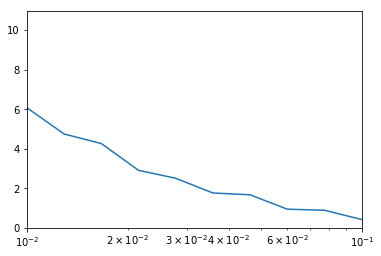

In [4]:
plt.semilogx(out[:,0],out[:,1])
#plt.semilogx(out[:,0],out[:,2])
plt.xlim([.01,.1])
plt.ylim([0,11])
plt.show()

In [282]:
out = []

for dt in [.05,.08]:
    out.append([dt,[]])
    for k in range(10):
        out[-1][-1].append([])
        FIL = out[-1][-1][-1]
        for T in range(0,int(1.5/dt),3):
            I = 20*np.ones([2,T,1])
            I2 = 20*np.zeros([2,int(1/dt),1])

            r = np.random.multivariate_normal(np.array([0]),C1d,[2,T+int(1./dt)])

            I = np.concatenate([I2,I],axis = 1) + r
            resp = inf.att_gexp(0,I,C1d,Q1d(dt),NC(1.),F1d(dt))

            FIL.append([T*dt,resp[0]])
            

In [283]:
OO = [np.array(out[i][1]) for i in range(len(out))]
D1 = [[OO[i][0,:,0],np.mean(OO[i][:,:,1],axis = 0),np.std(OO[i][:,:,1],axis = 0)] for i in range(len(OO))]

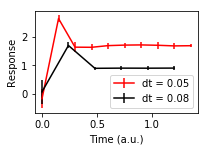

In [284]:
fig,sub=plt.subplots(1,1,figsize = (3,2.2))

sub.errorbar(D1[0][0],D1[0][1],yerr = D1[0][2],color="r",label = "dt = {}".format(out[0][0]))
sub.errorbar(D1[1][0],D1[1][1],yerr = D1[1][2],color="k",label = "dt = {}".format(out[1][0]))
sub.set_ylabel("Response")
sub.set_xlabel("Time (a.u.)")

plt.legend()
plt.tight_layout()
plt.savefig("./att_MGSM_Figures/param_att_temporal_resp.png")
plt.show()

In [36]:
import GSM.MGSM_inference as inf
import numpy as np

C1d = np.array([[1.,0],[0,1.]])
def F1d(dt):
    return np.exp(-dt)*np.array([[1,0],[0,1]])
def Q1d(dt):
    return inf.Q_self_con(C1d,F1d(dt))

def NC(snr):
    return C1d/(snr**2)

def sig(x):
    return 1./(1 + np.exp(-x))

dt = 1.
I = np.array([20*np.tile(np.array([[[2*sig(x) - 1,sig(x - 4)]]]),[10,10,1]) for x in np.linspace(0,16,10)])

r = np.random.multivariate_normal(np.array([0,0]),NC(1),[10,10,I.shape[2]])
print(I.shape)
respA = []
respI = []

for k in (I+r):
    print(k.shape)
    respA.append(inf.att_gexp(0,k[:,:int(k.shape[1]/2)],C1d,Q1d(dt/2),NC(1.),F1d(dt/2)))
    respI.append(inf.att_gexp(0,k,C1d,Q1d(dt),NC(1.),F1d(dt)))
    
respA = np.array(respA)
respI = np.array(respI)

(10, 10, 10, 2)
(10, 10, 2)
(10, 10, 2)
(10, 10, 2)
(10, 10, 2)
(10, 10, 2)
(10, 10, 2)
(10, 10, 2)
(10, 10, 2)
(10, 10, 2)
(10, 10, 2)


(10, 10)


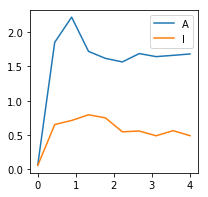

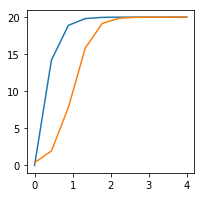

In [38]:
print(resp.shape)

import matplotlib.pyplot as plt

fig,sub = plt.subplots(1,1,figsize = (3,3))
fig.add_subplot()
sub.plot(np.linspace(0,4,10),[np.mean(k,axis = 0) for k in respA],label = "A")
sub.plot(np.linspace(0,4,10),[np.mean(k,axis = 0) for k in respI],label = "I")
sub.legend()
plt.show()

fig,sub = plt.subplots(1,1,figsize = (3,3))
fig.add_subplot()
sub.plot(np.linspace(0,4,10),I[:,0,0])
plt.show()

(100001, 2)
(50001, 2)
(100001, 2)
(100001, 2)


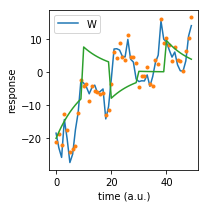

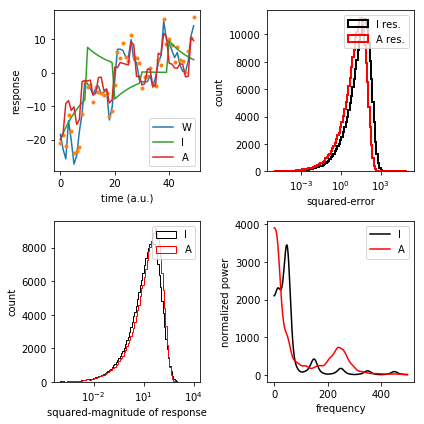

In [32]:
import GSM.MGSM_inference as inf
import scipy.linalg as linalg
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter as gfilt


def buildtrue(i,F,pn):
    out = [i]
    
    for k in range(len(pn)):
        out.append(np.dot(F,out[-1]) + pn[k])
        
    return np.array(out)

def FF(dt):
    return np.array([[np.exp(-dt/10),0],[0,np.exp(-dt/10)]])
def Q(dt,P):
    return inf.Q_self_con(P,FF(dt))

def interp(D,F,nint):
    out = []
    
    for d in range(len(D)):
        temp = [D[d]]
        for k in range(nint - 1):
            temp.append(np.dot(F,temp[-1]))
        out.append(np.array(temp))
    return np.concatenate(out)

PI = np.array([[1.,0],[0,1.]])
R = np.array([[5,0],[0,5]])
m = np.zeros(2)

N = 100000

init = np.random.multivariate_normal(m,PI)

procnoise = np.random.multivariate_normal(m,Q(1.,PI),N)
measnoise = np.random.multivariate_normal(m,R,N+1)

a = 10

true = a*buildtrue(init,FF(1.),procnoise)
meas = true + measnoise
print(true.shape)

ni = 10
na = 2

Ei=inf.att_egia(0,meas[::ni],1,a*a*PI,R,a*a*Q(ni,PI),FF(ni),getall=True)
Ea=inf.att_egia(0,meas[::na],1,a*a*PI,R,a*a*Q(na,PI),FF(na),getall=True)

print(meas[::na].shape)


Iint = interp(Ei,FF(1.),ni)[:len(true)]
Aint = interp(Ea,FF(1.),na)[:len(true)]
print(Iint.shape)
print(Aint.shape)


fig,sub = plt.subplots(1,1,figsize=(3,3))

subf = sub
subf.plot(true[:50,0],label = "W")
subf.plot((true + measnoise)[:50,0],".")
subf.plot(Iint[:50,0])
#subf.plot(Aint[:50,0],label = "A")
subf.set_xlabel("time (a.u.)")
subf.set_ylabel("response")
subf.legend()
plt.tight_layout()

plt.savefig("./att_MGSM_Figures/kalman_natural_stim.pdf")
plt.savefig("./att_MGSM_Figures/kalman_natural_stim.png")

fig,sub = plt.subplots(2,2,figsize=(6,6))

subf = sub[0,0]
subf.plot(true[:50,0],label = "W")
subf.plot((true + measnoise)[:50,0],".")
subf.plot(Iint[:50,0],label="I")
subf.plot(Aint[:50,0],label = "A")
subf.set_xlabel("time (a.u.)")
subf.set_ylabel("response")
subf.legend()

subf = sub[0,1]
subf.hist(np.reshape((true-Iint)**2,[-1]),np.logspace(-5,5,100),color="k",linewidth=2,label = "I res.",histtype="step")
subf.hist(np.reshape((true-Aint)**2,[-1]),np.logspace(-5,5,100),color="r",linewidth=2,label = "A res.",histtype="step")
subf.set_xscale("log")
subf.set_xlabel("squared-error")
subf.set_ylabel("count")
subf.legend()

Ilfp = np.mean(np.array([np.fft.fft(a) for a in np.split(Iint[:100000,0],100)]),axis = 0)
Alfp = np.mean(np.array([np.fft.fft(a) for a in np.split(Aint[:100000,0],100)]),axis = 0)
#Alfp = np.fft.fft(Aint[:,0])/len(Aint)

Ip = gfilt(np.abs(Ilfp)**2,10)[:len(Ilfp)/2 - 0*ni]
Ap = gfilt(np.abs(Alfp)**2,10)[:len(Alfp)/2 - 0*ni]

subf = sub[1,1]
subf.plot(Ip,label = "I",color = "k")
subf.plot(Ap,label = "A",color="r")
subf.set_xlabel("frequency")
subf.set_ylabel("normalized power")
subf.legend()

subf = sub[1,0]
subf.hist((np.reshape(Iint,[-1]))**2,np.logspace(-4,4,100),label = "I",histtype="step",color = "k")
subf.hist((np.reshape(Aint,[-1]))**2,np.logspace(-4,4,100),label = "A",histtype="step",color = "r")
subf.set_xscale("log")
subf.set_xlabel("squared-magnitude of response")
subf.set_ylabel("count")
subf.legend()

plt.tight_layout()

plt.savefig("./att_MGSM_Figures/kalman_natural_resp.pdf")
plt.savefig("./att_MGSM_Figures/kalman_natural_resp.png")
plt.show()

(100001, 2)
(50001, 2)
(100001, 2)
(100001, 2)


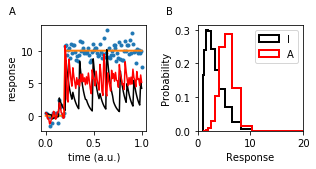

In [70]:
import GSM.MGSM_inference as inf
import scipy.linalg as linalg
import numpy as np
import matplotlib.pyplot as plt
def rect(x):
    return (x + np.abs(x))/2

onecol = 3.42
onep5 = 4.5
twocol = 7

def buildtrue(i,F,pn):
    out = [i]
    
    for k in range(len(pn)):
        out.append(np.dot(F,out[-1]) + pn[k])
        
    return np.array(out)

def FF(dt):
    return np.array([[np.exp(-dt/5),0],[0,np.exp(-dt/5)]])
def Q(dt,P):
    return inf.Q_self_con(P,FF(dt))

def interp(D,F,nint):
    out = []
    
    for d in range(len(D)):
        temp = [D[d]]
        for k in range(nint - 1):
            temp.append(np.dot(F,temp[-1]))
        out.append(np.array(temp))
    return np.concatenate(out)

PI = np.array([[1.,0],[0,1.]])
R = np.array([[1,0],[0,1]])
m = np.zeros(2)

N = 100000

init = np.random.multivariate_normal(m,PI)

procnoise = np.random.multivariate_normal(m,Q(1.,PI),N)
measnoise = np.random.multivariate_normal(m,R,N+1)

a = 10

true = a*np.concatenate([np.zeros_like(buildtrue(init,FF(1.),procnoise)[:20]),np.ones_like(buildtrue(init,FF(1.),procnoise)[20:])])
meas = true + measnoise
print(true.shape)

ni = 7
na = 2

Ei=inf.att_egia(0,meas[::ni],1,a*a*PI,R,a*a*Q(ni,PI),FF(ni),getall=True)
Ea=inf.att_egia(0,meas[::na],1,a*a*PI,R,a*a*Q(na,PI),FF(na),getall=True)

print(meas[::na].shape)


Iint = interp(Ei,FF(1.),ni)[:len(true)]
Aint = interp(Ea,FF(1.),na)[:len(true)]
print(Iint.shape)
print(Aint.shape)

fig,sub = plt.subplots(1,2,figsize=(onep5,onep5/2))

subf = sub[0]
n = 100
tt=np.linspace(0,1,n)
subf.plot(tt,(true + measnoise)[:n,0],".")
subf.plot(tt,true[:n,0],linewidth = 2)
subf.plot(tt,Iint[:n,0],"k")
subf.plot(tt,Aint[:n,0],"r")
#subf.plot(Aint[:50,0],label = "A")
subf.set_xlabel("time (a.u.)")
subf.set_ylabel("response")
subf.text(-.3,1.1,"A",transform = subf.transAxes)
subf.legend()

subf = sub[1]
subf.hist(rect(np.reshape(Iint,[-1])),np.logspace(0,10,100),label = "I",histtype="step",color = "k",linewidth = 2,normed = True)
subf.hist(rect(np.reshape(Aint,[-1])),np.logspace(0,10,100),label = "A",histtype="step",color = "r",linewidth = 2,normed = True)
#subf.set_xscale("log")
subf.set_xlim([0,20])
subf.set_xlabel("Response")
subf.set_ylabel("Probability")
subf.text(-.3,1.1,"B",transform = subf.transAxes)
subf.legend()

plt.tight_layout()
plt.savefig("./att_MGSM_Figures/kalman_const_stim.pdf",bbox_inches="tight")
plt.savefig("./att_MGSM_Figures/kalman_const_stim.png",bbox_inches="tight")
plt.show()

In [71]:
import time

Tn = 40
rep = 1
Nsam = 10

ni = 4
na = 2

outI = []
outA = []

for k in range(Nsam):
    T1 = time.time()
    print(k)
    Tinit = np.random.multivariate_normal(m,PI,[rep])

    Tprocnoise = np.random.multivariate_normal(m,Q(1.,PI),[rep,Tn])
    Tmeasnoise = np.random.multivariate_normal(m,R,[rep,Tn+1])

    Ta = np.random.rayleigh(1,size = [rep,1,1])

    Ttrue = Ta*np.array([buildtrue(Tinit[j],FF(1.),Tprocnoise[j]) for j in range(rep)])
    Tmeas = Ttrue + Tmeasnoise
   
    Eai = [inf.general_MGSM_g_att(Tmeas[:,:j:ni],[[[0,1]]],[[PI]],[[R]],[[Q(ni,PI)]],[[FF(ni)]],[[1.]],[0,1],stable = True,op=False) for j in range(1,len(Tmeas[0]),ni)]
    Eaa = [inf.general_MGSM_g_att(Tmeas[:,:j:na],[[[0,1]]],[[PI]],[[R]],[[Q(na,PI)]],[[FF(na)]],[[1.]],[0,1],stable = True,op=False) for j in range(1,len(Tmeas[0]),na)]
        
    outI.append(Eai)
    outA.append(Eaa)
    
    T2 = time.time()
    print(T2-T1)
    T1 = T2
    
outI = np.reshape(np.transpose(np.array(outI),[0,2,1,3]),[Nsam*rep,-1,2])
outA = np.reshape(np.transpose(np.array(outA),[0,2,1,3]),[Nsam*rep,-1,2])

0


KeyboardInterrupt: 

(10, 10, 2)
(10, 20, 2)
(20,)


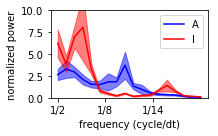

In [272]:
from scipy.ndimage.filters import gaussian_filter as gfilt

def rect(x):
    return (x + np.abs(x))/2

print(np.array(outI).shape)
print(np.array(outA).shape)

OI = np.array([interp(a,FF(1.),ni) for a in outI])
OA = np.array([interp(a,FF(1.),na) for a in outA])

OI = np.sqrt(rect(OI[:,:,0])**2+rect(OI[:,:,1])**2)
OA = np.sqrt(rect(OA[:,:,0])**2+rect(OA[:,:,1])**2)

nni = 0

Aft = np.array([(np.abs(np.fft.fft(b[:]))**2)[:len(b)/2 - nni*ni] for b in OA])
Ift = np.array([(np.abs(np.fft.fft(b[:]))**2)[:len(b)/2 - nni*ni] for b in OI])

Ast = [np.mean(Aft,axis = 0),np.std(Aft,axis = 0)/np.sqrt(len(Aft))]
Ist = [np.mean(Ift,axis = 0),np.std(Ift,axis = 0)/np.sqrt(len(Ift))]

cut = 2

print(Ast[0].shape)
fig,sub=plt.subplots(1,1,figsize=(3,2))
sub.plot(np.linspace(cut,len(Ast[0]),len(Ast[0])-cut),Ast[0][cut:],color = "b",label = "A")
sub.fill_between(np.linspace(cut,len(Ast[0]),len(Ast[0])-cut),Ast[0][cut:]-Ast[1][cut:],Ast[0][cut:]+Ast[1][cut:],color = "b",alpha=.5)

sub.plot(np.linspace(cut,len(Ast[0]),len(Ast[0])-cut),Ist[0][cut:],color = "r",label = "I")
sub.fill_between(np.linspace(cut,len(Ast[0]),len(Ast[0])-cut),Ist[0][cut:] - Ist[1][cut:],Ist[0][cut:] + Ist[1][cut:],color = "r",alpha=.5)
sub.set_xlabel("frequency (cycle/dt)")
sub.set_ylabel("normalized power")
sub.set_xticks(range(cut,len(Ast[0]),6))
sub.set_xticklabels(["1/{}".format(a+1) for a in range(1,len(Ast[0]),6)])
sub.set_ylim([0,10])

plt.legend()
plt.tight_layout()
plt.savefig("./att_MGSM_Figures/att_param_LFP.pdf")
plt.savefig("./att_MGSM_Figures/att_param_LFP.png")
plt.show()

In [72]:
def dot2(A,B):
    return np.dot(A,B)

def dot(A):
    if len(A) == 1:
        return A[0]
    elif len(A) == 2:
        return dot2(A[0],A[1])
    else:
        return dot(A[:-2] + [dot2(A[-2],A[-1])])

def dp(P,F,G,Q,H,R,tau):
        return dot([F,P]) + dot([P,F.transpose()]) + dot([G,Q,G.transpose()]) - dot([P,H.transpose(),np.linalg.inv(R),H,P])
def dx(x,z,P,F,H,R,tau):
    return dot([F,x]) + dot([P,H.transpose(),np.linalg.inv(R),z - dot([H,x])])

def makez(pad,T,a,Q):
    z = np.ones([T,2])*a
    z = np.concatenate([np.zeros_like(z[:pad]),z[pad:]]) + np.random.multivariate_normal(np.zeros(2),Q,[T])

    return z

def make_nat_s(T,P,F,Q,G,R,dt):
    q = dot([G,Q,G.transpose()])*dt
    r = R/dt
    up = np.eye(F.shape[0]) + dt*F
    
    z0 = [np.random.multivariate_normal(np.zeros(2),P)]
    s0 = [z0[0] + np.random.multivariate_normal(np.zeros(2),r)]
          
    qi = np.random.multivariate_normal(np.zeros(2),q,[int(T/dt)-1])
    ri = np.random.multivariate_normal(np.zeros(2),r,[int(T/dt)-1])
    
    for k in range(int(T/dt)-1):
        z0.append(dot([up,z0[-1]]) + qi[k])
        s0.append(z0[-1] + ri[k])
        
    z0 = np.array(z0)
    s0 = np.array(s0)
        
    return s0,z0

def make_const_s(T,P,F,Q,G,R,dt):
    q = dot([G,Q,G.transpose()])*dt
    r = R/dt
    up = np.eye(F.shape[0]) + dt*F
    
    z0 = np.ones([int(T/dt),2])
    s0 = [z0[0] + np.random.multivariate_normal(np.zeros(2),r)]
          
    ri = np.random.multivariate_normal(np.zeros(2),r,[int(T/dt)])
    
    for k in range(int(T/dt)):
        s0.append(z0[k] + ri[k])
        
    z0 = np.array(z0)
    s0 = np.array(s0)
        
    return s0,z0

def make_meas(state,P,F,Q,G,R,dt):    
    q = dot([G,Q,G.transpose()])*dt
    r = R/dt
 
    return state + np.random.multivariate_normal(np.zeros(2),r,[len(state)])

def get_resp(tau,F,H,RR,G,Q,P0,x0,dt,T,state,noise = None):
    
    R = tau*RR
    
    xm = [x0]
    pm = [P0]
    if noise is None:
        zz = make_meas(state,P0,F,Q,G,R,dt)
    else:
        zz = stim + noise

    
    for k in range(int(T/dt)):
        xm.append(xm[-1] + dt * dx(xm[-1],zz[k],pm[-1],F,H,R,tau))
        pm.append(pm[-1] + dt * dp(pm[-1],F,G,Q,H,R,tau))

    xm = np.array(xm)
    pm = np.array(pm)
    zz = np.array(zz)
    
    return xm,pm,zz
def inv(x):
    return np.linalg.inv(x)

def dx_app(x,z,P,F,H,R,tau):
    
    p = (1./2)*dot([inv(F),(Q - dot([H,H,inv(R),inv(F),inv(F),Q,Q])/4)])
    
    return dot([F,x]) + dot([p,H.transpose(),np.linalg.inv(R),z - dot([H,x])])

def get_app_resp(tau,F,H,RR,G,Q,P0,x0,dt,T,state,noise = None):
    
    R = tau*RR
    
    xm = [x0]

    if noise is None:
        zz = make_meas(state,P0,F,Q,G,R,dt)
    else:
        zz = stim + noise
        
    for k in range(int(T/dt)):
        xm.append(xm[-1] + dt * dx_app(xm[-1],zz[k],pm[-1],F,H,R,tau))

    xm = np.array(xm)
    zz = np.array(zz)
    
    return xm,zz

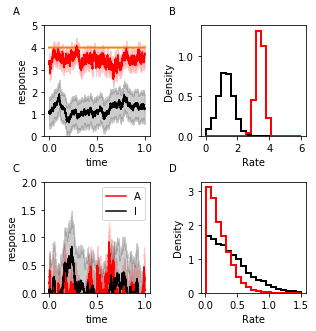

In [109]:
F = - np.eye(2)
H = np.eye(2)
R = np.eye(2)/5
G = np.eye(2)
Q = np.eye(2)

x0 = np.zeros(2)
P0 = np.eye(2)


dt = .001
T = 20.

tau1 = 5.
tau2 = .1

meas,cstim = make_const_s(T,P0,F,Q,G,R,dt)

cstim*=4
cpl = np.copy(cstim)
x1,p1,zz1 = get_resp(tau1,F,H,R,G,Q,P0,x0,dt,T,cstim)
x2,p2,zz2 = get_resp(tau2,F,H,R,G,Q,P0,x0,dt,T,cstim)

cstim*=0

cx1,cp1,czz1 = get_resp(tau1,F,H,R,G,Q,P0,x0,dt,T,cstim)
cx2,cp2,czz2 = get_resp(tau2,F,H,R,G,Q,P0,x0,dt,T,cstim)

# fig,sub = plt.subplots(2,3,figsize = (9,6))
# #fig,sub = plt.subplots(3,3,figsize = (9,9))

# subf = sub[0,0]
# subf.plot(x2[-10000:,0],label = "A",color="r")
# subf.plot(stim[-10000:,0],label = "Truth",color="g")
# subf.plot(x1[-10000:,0],label = "I",color="k")
# subf.set_ylim([-3,3])
# subf.set_xlabel("time")
# subf.set_ylabel("response")
# subf.legend()

# subf = sub[0,1]
# subf.hist(np.reshape(x1[1:] - stim,[-1])**2,np.logspace(-5,2,50),label = "I",histtype = "step",linewidth =2,color = "k")
# subf.hist(np.reshape(x2[1:] - stim,[-1])**2,np.logspace(-5,2,50),label = "A" ,histtype = "step",linewidth =2,color = "r")
# subf.set_xlabel("Error")
# subf.set_ylabel("Counts")
# subf.set_xscale("log")
# subf.text(.1,.8,"$\delta I^2 = {}$".format(np.round(np.mean((x1[1:] - stim)**2),2)),transform = subf.transAxes)
# subf.text(.1,.7,"$\delta A^2 = {}$".format(np.round(np.mean((x2[1:] - stim)**2),2)),transform = subf.transAxes)

# subf = sub[0,2]
# subf.hist(np.reshape(np.abs(x1[1:]),[-1]),np.logspace(-5,2,50),label = "I",histtype = "step",linewidth =2,color = "k")
# subf.hist(np.reshape(np.abs(x2[1:]),[-1]),np.logspace(-5,2,50),label = "A" ,histtype = "step",linewidth =2,color="r")
# subf.set_xlabel("|Rate|")
# subf.set_ylabel("Counts")
# subf.text(.1,.8,"$|I| = {}$".format(np.round(np.mean(np.abs(x1[1:])),2)),transform = subf.transAxes)
# subf.text(.1,.7,"$|A| = {}$".format(np.round(np.mean(np.abs(x2[1:])),2)),transform = subf.transAxes)
# subf.set_xscale("log")

# plt.clf()

fig,sub = plt.subplots(2,2,figsize = (onep5,onep5))

tt = np.linspace(0,1,10000)
subf = sub[0,0]

subf.plot(tt,cpl[-10000:,0],color = '#ff7f0e',linewidth = 2)
subf.plot(tt,x2[-10000:,0],label = "A",color = "r")
subf.fill_between(tt,x2[-10000:,0] - np.sqrt(p2[-10000:,0,0]),x2[-10000:,0] + np.sqrt(p2[-10000:,0,0]),color = "r",alpha = .2)

subf.plot(tt,x1[-10000:,0],label = "I",color = "k")
subf.fill_between(tt,x1[-10000:,0] - np.sqrt(p1[-10000:,0,0]),x1[-10000:,0] + np.sqrt(p1[-10000:,0,0]),color = "k",alpha = .2)

subf.set_xlabel("time")
subf.set_ylabel("response")
subf.set_ylim([0,5])
subf.text(-.3,1.1,"A",transform = subf.transAxes)

subf = sub[0,1]

cc1 = [x1[k,0] + np.random.normal(0,p1[k,0,0]) for k in range(len(x1))]
cc2 = [x2[k,0] + np.random.normal(0,p2[k,0,0]) for k in range(len(x2))]


subf.hist(np.reshape(rect(cc1[1:]),[-1]),np.linspace(0,6,20),label = "I",histtype = "step",linewidth =2,color="k",normed = True)
subf.hist(np.reshape(rect(cc2[1:]),[-1]),np.linspace(0,6,20),label = "A" ,histtype = "step",linewidth =2,color="r",normed = True)
subf.set_xticks([0,2,4,6])
subf.set_xlabel("Rate")
subf.set_ylabel("Density")
subf.text(-.3,1.1,"B",transform = subf.transAxes)

tt = np.linspace(0,1,10000)
subf = sub[1,0]
subf.plot(tt,cx2[-10000:,0],label = "A",color = "r")
subf.fill_between(tt,cx2[-10000:,0] - np.sqrt(cp2[-10000:,0,0]),cx2[-10000:,0] + np.sqrt(cp2[-10000:,0,0]),color = "r",alpha = .2)

subf.plot(tt,cx1[-10000:,0],label = "I",color = "k")
subf.fill_between(tt,cx1[-10000:,0] - np.sqrt(cp1[-10000:,0,0]),cx1[-10000:,0] + np.sqrt(cp1[-10000:,0,0]),color = "k",alpha = .2)

subf.set_xlabel("time")
subf.set_ylabel("response")
subf.set_ylim([0,2])
subf.legend()
subf.text(-.3,1.1,"C",transform = subf.transAxes)

subf = sub[1,1]

cc1 = [cx1[k,0] + np.random.normal(0,cp1[k,0,0]) for k in range(len(cx1))]
cc2 = [cx2[k,0] + np.random.normal(0,cp2[k,0,0]) for k in range(len(cx2))]


subf.hist(np.reshape(rect(cc1[1:]),[-1]),np.linspace(.01,1.5,20),label = "I",histtype = "step",linewidth =2,color="k",normed = True)
subf.hist(np.reshape(rect(cc2[1:]),[-1]),np.linspace(.01,1.5,20),label = "A" ,histtype = "step",linewidth =2,color="r",normed = True)
subf.set_xticks([0,.5,1,1.5])
subf.set_xlabel("Rate")
subf.set_ylabel("Density")
subf.text(-.3,1.1,"D",transform = subf.transAxes)
#subf.set_xscale("log")
'''

meas,zstim = make_const_s(T,P0,F,Q,G,R,dt)

zstim*=0

zx1,cp1,czz1 = get_resp(tau1,F,H,R,G,Q,P0,x0,dt,T,zstim)
zx2,cp2,czz2 = get_resp(tau2,F,H,R,G,Q,P0,x0,dt,T,zstim)

subf = sub[2,0]
subf.plot(zx2[-10000:,0],label = "A",color = "r")
subf.plot(zstim[-10000:,0],label = "True",color="g")
subf.plot(zx1[-10000:,0],label = "I",color="k")
subf.set_xlabel("time")
subf.set_ylabel("response")
subf.set_ylim([-1,1])

subf = sub[2,1]
subf.hist(np.reshape(zx1[1:] - zstim,[-1])**2,np.logspace(-5,1,50),label = "I",histtype = "step",linewidth =2,color="k")
subf.hist(np.reshape(zx2[1:] - zstim,[-1])**2,np.logspace(-5,1,50),label = "A" ,histtype = "step",linewidth =2,color="r")
subf.set_xlabel("Error")
subf.set_ylabel("Counts")
subf.set_xscale("log")
subf.text(.1,.8,"$\delta I^2 = {}$".format(np.round(np.mean((zx1[1:] - zstim)**2),2)),transform = subf.transAxes)
subf.text(.1,.7,"$\delta A^2 = {}$".format(np.round(np.mean((zx2[1:] - zstim)**2),2)),transform = subf.transAxes)

subf = sub[2,2]
subf.hist(np.reshape(np.abs(zx1[1:]),[-1]),np.logspace(-2,1,50),label = "I",histtype = "step",linewidth =2,color="k")
subf.hist(np.reshape(np.abs(zx2[1:]),[-1]),np.logspace(-2,1,50),label = "A" ,histtype = "step",linewidth =2,color="r")
subf.set_xlabel("|Rate|")
subf.set_ylabel("Counts")
subf.set_xscale("log")
'''

plt.tight_layout()
plt.savefig("./att_MGSM_Figures/continuum_kalman_fig.pdf",bbox_inches = "tight")
plt.savefig("./att_MGSM_Figures/continuum_kalman_fig.jpg")

plt.show()

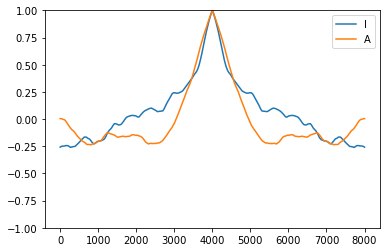

In [680]:
def xcorr_maxlag(x, y, maxlag=1.0):
    """
    Compute the cross-correlogram of two time series.
    """
    xl = x.size
    yl = y.size

    c = np.zeros(2*maxlag + 1)

    for i in xrange(maxlag+1):
        tmp = np.corrcoef(x[0:min(xl, yl-i)], y[i:i+min(xl, yl-i)])
        c[maxlag-i] = tmp[1][0]
        tmp = np.corrcoef(x[i:i+min(xl-i, yl)], y[0:min(xl-i, yl)])
        c[maxlag+i] = tmp[1][0]

    return c

A = xcorr_maxlag(cx1[:,0],cx1[:,0],4000)
B = xcorr_maxlag(cx2[:,0],cx2[:,0],4000)

plt.plot(A,label = "I")
plt.plot(B,label = "A")
plt.legend()
plt.ylim([-1,1])
plt.show()

In [706]:
F = - np.eye(2)
H = np.eye(2)
R = np.eye(2)
G = np.eye(2)
Q = np.array([[np.cos(.1),np.sin(.1)],[np.sin(.1),np.cos(.1)]])#np.eye(2)

x0 = np.zeros(2)
P0 = np.eye(2)

dt = .001
T = 20.

tau1 = 5.
tau2 = .1

meas,cstim = make_const_s(T,P0,F,Q,G,R,dt)

cstim*=10
ostim = cstim*np.array([[1,0]])

print(cstim[0])
print(ostim[0])

[ 10.  10.]
[ 10.   0.]


In [707]:
cx1,cp1,czz1 = get_resp(tau2,F,H,R,G,Q,P0,x0,dt,T,cstim)
cx2,cp2,czz2 = get_resp(tau2,F,H,R,G,Q,P0,x0,dt,T,ostim)

Ar=1. - np.mean(cx2[:,0])/np.mean(cx1[:,0])

tcx1,cp1,czz1 = get_resp(tau1,F,H,R,G,Q,P0,x0,dt,T,cstim)
tcx2,cp2,czz2 = get_resp(tau1,F,H,R,G,Q,P0,x0,dt,T,ostim)

Ir=1. - np.mean(tcx2[:,0])/np.mean(tcx1[:,0])

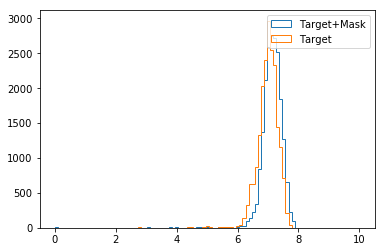

In [708]:
plt.hist(cx1[:,0],np.linspace(0,10,100),histtype="step",label = "Target+Mask")
plt.hist(cx2[:,0],np.linspace(0,10,100),histtype="step",label = "Target")
plt.legend()
plt.show()

In [709]:
print(Ar,Ir)

(0.019810530519578484, 0.15864573458105047)


In [756]:
tau = 100.

noise = np.random.multivariate_normal(np.zeros(2),tau*R,len(stim))

acx1,czz1 = get_app_resp(tau,F,H,R,G,Q,P0,x0,dt,T,stim,noise = noise)
acx2,p,czz2 = get_resp(tau,F,H,R,G,Q,P0,x0,dt,T,stim,noise = noise)


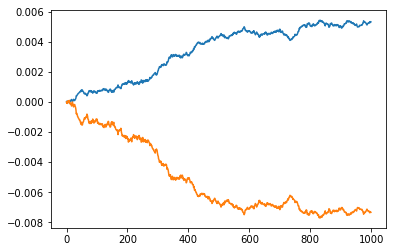

In [757]:
plt.plot(acx1[:1000,0])
plt.plot(acx2[:1000,0])
plt.show()

In [204]:
def dot2(A,B):
    return np.dot(A,B)

def dot(A):
    if len(A) == 1:
        return A[0]
    elif len(A) == 2:
        return dot2(A[0],A[1])
    else:
        return dot(A[:-2] + [dot2(A[-2],A[-1])])


def temp_cor_step(x,P,z,par):
    R1 = dot([par["H"],par["Q"],par["H"].transpose()]) + par["J"]
    C1 = dot([par["Q"],par["H"].transpose()])
    H1 = dot([par["H"],par["F"]]) - dot([par["E"],par["H"]])

    k1 = dot([(dot([P,H1.transpose()]) + C1),np.linalg.inv(R1)])
    
    pdot = dot([par["F"],P]) + dot([P,par["F"].transpose()]) + par["Q"] - dot([k1,R1,k1.transpose()])
    
    k1dot = dot([dot([pdot,H1.transpose()]),np.linalg.inv(R1)])
    
    xzdot = dot([par["F"],x]) - dot([k1dot,z]) - dot([k1,(dot([par["E"],z]) + dot([H1,x]))])
    
    return xzdot,pdot,k1

def filter(Z,par):
    P = [par["P0"]]
    
    x0 = par["x0"] + dot([par["P0"],par["H"].transpose(),np.linalg.inv(dot([par["H"],par["P0"],par["H"].transpose()]) + par["R"]),Z[0] - dot([par["H"],par["x0"]])])
    P0 = par["P0"] - dot([par["P0"],par["H"].transpose(),np.linalg.inv(dot([par["H"],par["P0"],par["H"].transpose()]) + par["R"]),dot([par["H"],par["P0"]])])
    
    X = [x0]
    P = [P0]
    
    H1 = dot([par["H"],par["F"]]) - dot([par["H"],par["E"]])
    C1 = dot([par["Q"],par["H"].transpose()])
    R1 = dot([par["H"],par["Q"],par["H"].transpose()]) + par["J"]
    
    k10 = dot([dot([par["P0"],H1]) + C1,np.linalg.inv(R1)])
    xz = [X[-1] - dot([k10,Z[0]])]
    
    for z in Z:
        dxz, dp, k1 = temp_cor_step(X[-1],P[-1],z,par)
        xz.append(xz[-1] + par["dt"]*dxz)
        P.append(P[-1] + par["dt"]*dp)
        X.append(xz[-1] + dot([k1,z]))
          
    return np.array(X),np.array(P),np.array(xz)
          

        

In [329]:
import numpy as np

T = 2.
zT = .1
dt = .0001
NN = int(T/dt)
NZ = int(zT/dt)

tf = 1. #halflife of the signal (ms)
f = np.log(2.)/tf

id = np.array([[1]])

a = 10

par = {}

par["dt"] = dt
par["x0"] = np.array([0])
par["P0"] = np.array([1])

par["R"] = 1. * id

par["F"] = -f * id * par["dt"]
par["Q"] = 2 * f * par["P0"] * par["dt"]

par["H"] = np.array([[a]])

In [330]:
tau = .1
e = np.log(2)/tau
par["E"] = -e * id * par["dt"]
par["J"] = 2 * e * par["R"] * par["dt"]

XXi = []
for k in range(10):
    z = np.ones([NN,len(par["R"])])
    z = np.concatenate([0*z[:NZ],15*z,0*z[:NZ]])
    z += np.random.multivariate_normal(np.array([0]),par["R"],size = [len(z)])
    
    x,p,xz = filter(z,par)
    
    XXi.append(x)
    
XXi = np.array(XXi)

In [331]:
tau = .01
e = np.log(2)/tau
par["E"] = -e * id * par["dt"]
par["J"] = 2 * e * par["R"] * par["dt"]

XXa = []
for k in range(10):
    z = np.ones([NN,len(par["R"])])
    z = np.concatenate([0*z[:NZ],15*z,0*z[:NZ]])
    z += np.random.multivariate_normal(np.array([0]),par["R"],size = [len(z)])

    x,p,xz = filter(z,par)
    
    XXa.append(x)
    
XXa = np.array(XXa)

(8204.8999999999996, 1936.2888030973063)
(10531.799999999999, 1932.735961273552)


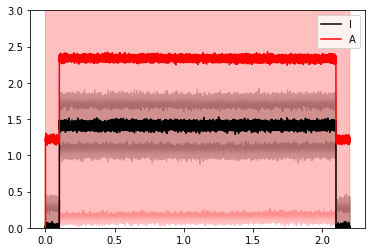

In [332]:
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter as gfilt

Im = np.mean(XXi,axis = 0)[:,0]
Is = np.std(XXi,axis = 0)[:,0]

Am = np.mean(XXa,axis = 0)[:,0]
As = np.std(XXa,axis = 0)[:,0]
xx = np.linspace(0,(NN + 2*NZ)*par["dt"],len(Am))

#plt.plot(xx,XXi[0,:,0],label = "I",color = "k")
plt.plot(xx,Im,label = "I",color = "k")
plt.fill_between(xx,Im - Is, Im + Is,alpha = .25,color = "k")

#plt.plot(xx,XXa[5,:,0],label = "A",color = "r")
plt.plot(xx,Am,label = "A",color = "r")
plt.fill_between(xx,Am - As, Am + As,alpha = .25,color = "r")
plt.ylim([0,3])

plt.legend()
plt.show()

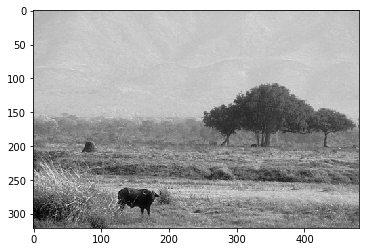

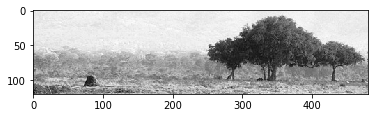

In [221]:
import matplotlib.pyplot as plt
import matplotlib.patches as patch

import numpy as np

def g(x,m,s):
    return np.exp(-(1./2)*((x - m)/s)**2)/(np.sqrt(2*np.pi*s*s))

from scipy.ndimage import imread
import glob

ifunc = glob.glob("./../../data/BSDS300/images/test/*.jpg")
A = 1-np.mean(imread(ifunc[1]),axis = 2)
plt.imshow(A,cmap = "Greys")
plt.show()
plt.imshow(A[100:220],cmap = "Greys")
plt.show()

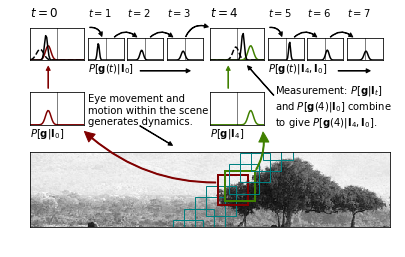

In [140]:

import matplotlib.pyplot as plt
import matplotlib.patches as patch

import numpy as np

def g(x,m,s):
    return np.exp(-(1./2)*((x - m)/s)**2)/(np.sqrt(2*np.pi*s*s))

from scipy.ndimage import imread
import glob

ifunc = glob.glob("./../../data/BSDS300/images/test/*.jpg")
A = 1-np.mean(imread(ifunc[1]),axis = 2)
import matplotlib.pyplot as plt
import matplotlib.colors as colors

c1 = colors.hsv_to_rgb((0,1,.5))
c2 = colors.hsv_to_rgb((.25,1,.5))
c3 = colors.hsv_to_rgb((.5,1,.5))
fig=plt.figure(figsize=(5,3))
MAINax = fig.add_axes([0,0,1,1])

f = .5
q = .25

ymax = 3.

pnt=np.linspace(-3,3,50)


si = .4
mi = -1.9

s1= si
m1 = mi

s2 = .3
m2 = -1.

si = ((1./s1)+(1./s2))**-1
mi = si*((m1/s1) + (m2/s1))

ax = fig.add_axes([0,.8,.15,.15])
ax.plot(pnt,g(pnt,m1,s1),"k--")
ax.plot(pnt,g(pnt,m2,s2),color=c1)
ax.plot(pnt,g(pnt,mi,si),"k")
ax.plot([0,0],[0,100],"k",linewidth=.5)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_ylim([0,ymax])
ax.set_xlim([-3,3])

for k in range(3):
    ax = fig.add_axes([.16+k*.11,.8,.1,.1])
    ax.plot(pnt,g(pnt,mi,si),"k")
    ax.plot([0,0],[0,100],"k",linewidth=.5)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_ylim([0,ymax])
    ax.set_xlim([-3,3])

    for j in range(1):
        si = f*f*si + q
        mi = mi*f

ax = fig.add_axes([.0,.5,.15,.15])
ax.plot(pnt,g(pnt,m2,s2),color = c1)
ax.plot([0,0],[0,100],"k",linewidth=.5)
ax.set_ylim([0,ymax])
ax.set_xlim([-3,3])

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

ax = fig.add_axes([.5,.8,.15,.15])
s1=si
m1 = mi

s2 = .3
m2 = 1.5

si = ((1./s1)+(1./s2))**-1
mi = si*((m1/s2) + (m2/s1))

ax.plot(pnt,g(pnt,m1,s1),"k--")
ax.plot(pnt,g(pnt,m2,s2),color = c2)
ax.plot(pnt,g(pnt,mi,si),"k")
ax.plot([0,0],[0,100],"k",linewidth=.5)
ax.set_ylim([0,ymax])
ax.set_xlim([-3,3])
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

ax = fig.add_axes([.5,.5,.15,.15])
ax.plot(pnt,g(pnt,m2,s2),color = c2)
ax.plot([0,0],[0,100],"k",linewidth=.5)
ax.set_ylim([0,ymax])
ax.set_xlim([-3,3])

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

for k in range(3):
    ax = fig.add_axes([.66+k*.11,.8,.1,.1])
    ax.plot(pnt,g(pnt,mi,si),"k")
    ax.plot([0,0],[0,100],"k",linewidth=.5)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_ylim([0,ymax])
    ax.set_xlim([-3,3])

    for j in range(1):
        si = f*f*si + q
        mi = mi*f

##arrows
style="Simple,tail_width=0.5,head_width=4,head_length=4"
kw = dict(arrowstyle=style, color="k")
kw2 = dict(arrowstyle=style,color=c2)
kw3 = dict(arrowstyle=style,color=c1)

ax = MAINax

ax.add_patch(patch.FancyArrowPatch((.55,.66),(.55,.78),connectionstyle="arc3,rad=0",**kw2))
ax.add_patch(patch.FancyArrowPatch((.05,.66),(.05,.78),connectionstyle="arc3,rad=0",**kw3))


ax.add_patch(patch.FancyArrowPatch((.16,.95),(.2,.9),connectionstyle="arc3,rad=-.5",**kw))
ax.add_patch(patch.FancyArrowPatch((.23,.9),(.3,.9),connectionstyle="arc3,rad=-.5",**kw))
ax.add_patch(patch.FancyArrowPatch((.33,.9),(.4,.9),connectionstyle="arc3,rad=-.5",**kw))
ax.add_patch(patch.FancyArrowPatch((.43,.9),(.5,.95),connectionstyle="arc3,rad=-.5",**kw))

ax.add_patch(patch.FancyArrowPatch((.66,.95),(.7,.9),connectionstyle="arc3,rad=-.5",**kw))
ax.add_patch(patch.FancyArrowPatch((.73,.9),(.8,.9),connectionstyle="arc3,rad=-.5",**kw))
ax.add_patch(patch.FancyArrowPatch((.83,.9),(.9,.9),connectionstyle="arc3,rad=-.5",**kw))

##text
ax.text(0,1,"$t = 0$",fontsize = 12)
ax.text(.16,1,"$t = 1$",fontsize = 10)
ax.text(.27,1,"$t = 2$",fontsize = 10)
ax.text(.38,1,"$t = 3$",fontsize = 10)

ax.text(.5,1,"$t = 4$",fontsize = 12)
ax.text(.66,1,"$t = 5$",fontsize = 10)
ax.text(.77,1,"$t = 6$",fontsize = 10)
ax.text(.88,1,"$t = 7$",fontsize = 10)

B = A[100:200]
ax = fig.add_axes([0,0,1,.4],zorder=0)
ax.imshow(B,cmap="Greys",zorder = 0)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
for k in range(10):
    ax.add_patch(patch.Rectangle([250-(10-k)*15,30+(10-k)*15],40,40,facecolor=(0,0,0,0),edgecolor=c3,linewidth=1))

ax.add_patch(patch.Rectangle([250,30],40,40,facecolor=(0,0,0,0),edgecolor=c1,linewidth=2))
ax.add_patch(patch.Rectangle([260,25],40,40,facecolor=(0,0,0,0),edgecolor=c2,linewidth=2))
for k in range(10):
    ax.add_patch(patch.Rectangle([250+(10-k)*15,30-(10-k)*15],40,40,facecolor=(0,0,0,0),edgecolor=c3,linewidth=1))

#ax = MAINax
style="Simple,tail_width=1,head_width=10,head_length=10"
kwI1 = dict(arrowstyle=style, color=c1)
kwI2 = dict(arrowstyle=style, color=c2)
ax.add_patch(patch.FancyArrowPatch((250,40),(70,-30),connectionstyle="arc3,rad=-.2",zorder = 100, clip_on=False,**kwI1))
ax.add_patch(patch.FancyArrowPatch((300,25),(310,-30),connectionstyle="arc3,rad=.2",zorder = 100, clip_on=False,**kwI2))
#ax.axis('off')

ax=MAINax
ax.text(0,.45,"$P[\mathbf{g}|\mathbf{I}_{0}]$")

ax.text(.16,.75,"$P[\mathbf{g}(t)|\mathbf{I}_{0}]$")
ax.add_patch(patch.FancyArrowPatch((.3,.75),(.45,.75),connectionstyle="arc3,rad=0",zorder = 100, clip_on=False,**kw))

ax.text(.5,.45,"$P[\mathbf{g}|\mathbf{I}_{4}]$")

ax.text(.66,.75,"$P[\mathbf{g}(t)|\mathbf{I}_{4},\mathbf{I}_{0}]$")
ax.add_patch(patch.FancyArrowPatch((.85,.75),(.95,.75),connectionstyle="arc3,rad=0",zorder = 100, clip_on=False,**kw))

ax.text(.68,.5,"Measurement: $P[\mathbf{g}|\mathbf{I}_{t}]$\nand $P[\mathbf{g}(4)|\mathbf{I}_{0}]$ combine\nto give $P[\mathbf{g}(4)|\mathbf{I}_{4},\mathbf{I}_{0}]$.")
ax.add_patch(patch.FancyArrowPatch((.68,.63),(.6,.78),connectionstyle="arc3,rad=0",zorder = 100, clip_on=False,**kw))

ax.text(.16,.5,"Eye movement and\nmotion within the scene\ngenerates dynamics.")
ax.add_patch(patch.FancyArrowPatch((.3,.5),(.4,.4),connectionstyle="arc3,rad=0",zorder = 1000000, clip_on=False,**kw))

MAINax.axis('off')
plt.savefig("./ModelGraphic.pdf",bbox_inches="tight")
plt.show()

In [61]:
import scipy 

def C(c):
    return np.array([[1.,c],[c,1.]])

def F1d(dt,v,c1,c2):
    return scipy.linalg.expm(dt * np.array([[v,c1],[c2,v]]))

def Q1d(dt,c,v,c1,c2):
    return inf.Q_self_con(C(c),F1d(dt,v,c1,c2))

def NC(snr,c):
    return C(c)/(snr**2)

In [64]:
Q1d(.1,.1,-.2,-.1,.1)

array([[ 0.03728911,  0.00394027],
       [ 0.00394027,  0.04113201]])

In [161]:

con = 10
nt = 100

II1 = con*np.ones([2,nt,2])*np.array([[[1,0]]])

dt = .1
c = -.1
v = -1.
c1 = .5
c2 = .5
snr = .6

dtdf = .5

cov = C(c)
ncov = NC(snr,c)
qcov = Q1d(dt,c,v,c1,c2)
F = F1d(dt,v,c1,c2)

out1 = np.array([inf.att_gexp(0,II1[:,:k],cov,ncov,qcov,F) for k in range(1,int(II1.shape[1]*dtdf),2)])

cov = C(c)
ncov = NC(snr,c)
qcov = Q1d(dt*dtdf,c,v,c1,c2)
F = F1d(dt*dtdf,v,c1,c2)

out2 = np.array([inf.att_gexp(0,II1[:,:k],cov,ncov,qcov,F) for k in range(1,int(II1.shape[1]),2)])

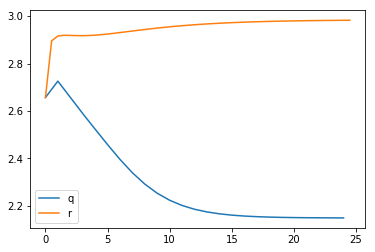

In [162]:
plt.plot(np.arange(len(out1)),out1[:,0],label = "q")
plt.plot(dtdf*np.arange(len(out2)),out2[:,0],label = "r")
plt.legend()
plt.show()

In [280]:
import numpy as np
import GSM.MGSM_inference as inf
from matplotlib import pyplot as plt
reload(inf)
snr = 2.
a = 10.
fg = .5
fn = .90

C = np.array([[snr,0],[0,1.]])
H = np.array([[a,0]])
F = np.array([[fg,0],[0,fn]])
Q = inf.Q_self_con(C,F)

NC = np.array([[.01]])

I = np.concatenate([np.zeros([10,1]),10*np.ones([100,1])],axis = 0)

n = np.random.randn(110,1)

m = [n[0]*np.sqrt(C[1,1])]
for i in n[1:]:
    m.append(F[1,1]*m[-1] + i*np.sqrt(Q[1,1]))
  
m = np.array(m)

I = I + m

print(I.shape)

res = inf.general_att_egia(I,H,C,NC,Q,F,getall = True)

(110, 1)


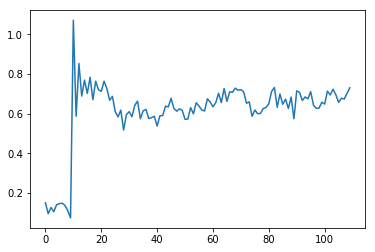

In [281]:
plt.plot(res[:,0])
plt.show()

In [292]:
def get_resp(c,snr,a,fg,fn,nc,L):

    C = np.array([[1.,0],[0,(1./snr)**2]])
    H = np.array([[a,1]])
    F = np.array([[fg,0],[0,fn]])
    Q = inf.Q_self_con(C,F)

    NC = np.array([[nc]])

    I = np.concatenate([c*np.ones([L,1])],axis = 0)

    n = np.random.randn(L,1)
    
    mm = np.random.multivariate_normal(np.zeros(1),NC,L)
    
    m = [n[0]*np.sqrt(C[1,1])]
    for i in n[1:]:
        m.append(F[1,1]*m[-1] + i*np.sqrt(Q[1,1]))
  
    m = np.array(m)

#    I = I + m + mm

    res = inf.general_att_egia(I,H,C,NC,Q,F,getall = True)
    return res

In [298]:
#(c,snr,a,fg,fn)
nx = 30
res = np.array([[get_resp(10.,1./fn,1,fg,.1,0,100) for fn in np.linspace(.5,3,nx)] for fg in np.linspace(0.001,1,nx)])
res2 = np.array([[get_resp(10.,2,1,fg,fn,0,100) for fn in np.linspace(.1,1,nx)] for fg in np.linspace(0.001,1,nx)])
#plt.plot(res[:,5,:,0].transpose())
#plt.ylim([0,10])
#plt.show()
#plt.plot(res[:,5,:,1].transpose())
#plt.ylim([0,1])
#plt.show()

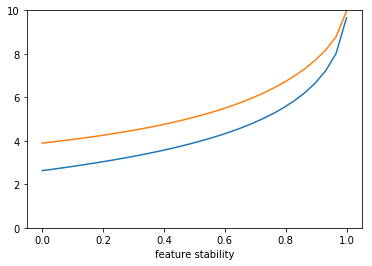

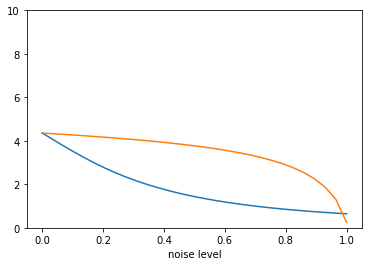

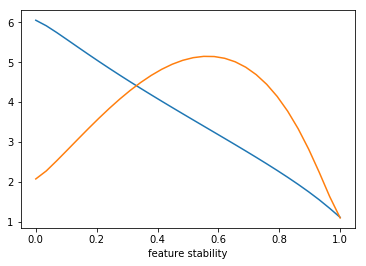

In [299]:
plt.plot(np.linspace(0,1,nx),res[:,5,10:,0].mean(axis = 1))
plt.plot(np.linspace(0,1,nx),res2[:,5,10:,0].mean(axis = 1))
plt.xlabel("feature stability")
plt.ylim([0,10])
plt.show()
plt.plot(np.linspace(0,1,nx),res[5,:,10:,0].mean(axis = 1))
plt.plot(np.linspace(0,1,nx),res2[5,:,10:,0].mean(axis = 1))
plt.xlabel("noise level")
plt.ylim([0,10])
plt.show()
plt.plot(np.linspace(0,1,nx),(res[:,3]/res[:,-2])[:,10:,0].mean(axis = 1))
plt.plot(np.linspace(0,1,nx),(res2[:,3]/res2[:,-2])[:,10:,0].mean(axis = 1))
plt.xlabel("feature stability")
plt.show()
